# Setup

In [9]:
import warnings

import numpy as np
import pandas as pd

import cv2
from PIL import Image
from matplotlib import pyplot as plt 
import os
import sys
import warnings

import torch
import torch.nn as nn
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

## Dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample

In [11]:
def load_data(path='fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping

In [12]:
def prepare_data():
    image_array = []
    image_label = []

    emotion_mapping = {'angry' : 0, 'disgust' : 1,'fear' : 2,'happy' : 3,'sad' : 4,'surprise' : 5, 'neutral' : 6}
    test_root_path = '../dataset/test/'
    for emotion_dir in os.listdir(test_root_path):
        for img_name in os.listdir(os.path.join(test_root_path,emotion_dir)):
            img = cv2.imread(os.path.join(test_root_path,emotion_dir,img_name),cv2.IMREAD_GRAYSCALE)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image_array.append(img)
            image_label.append(emotion_dir)
        


    image_label = list(map(lambda x: emotion_mapping[x], image_label))

    return np.array(image_array), np.array(image_label)


In [13]:
def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """



    xtest, ytest = prepare_data()

    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])


    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))
    test = CustomDataset(xtest, ytest, test_transform)
    testloader = DataLoader(test, batch_size=64, shuffle=True)

    return testloader


## Model Architecture

In [14]:
class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def show_plt(self):

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()



In [15]:
class Vgg(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.lin3 = nn.Linear(4096, 7)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)

        return x

In [25]:
# Load Trained Model
checkpoint = torch.load('./weights/VGGNet',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()


Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

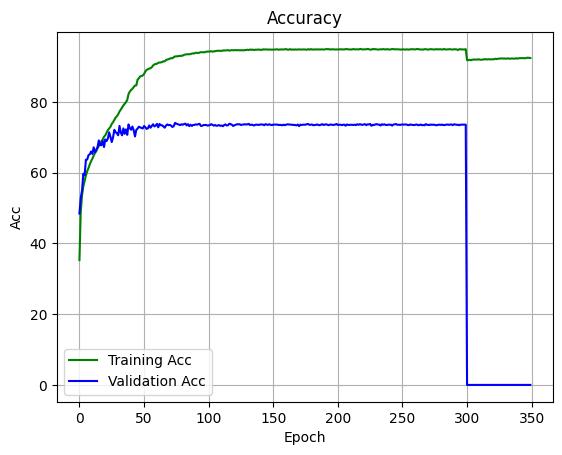

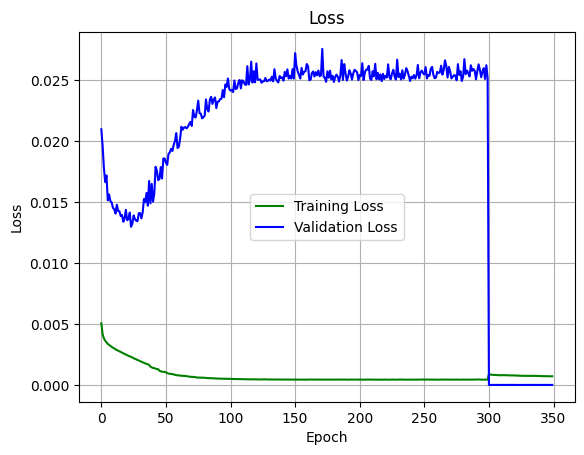

In [18]:
logger = Logger()
logger.restore_logs(checkpoint['logs'])
logger.show_plt()

#Evalutae model

In [17]:
def correct_count(output, target, topk=(1,)):
    """Computes the top k corrrect count for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res


In [22]:
def correct_count(output, target, topk=(1,)):
    """Computes the top k corrrect count for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res


def evaluate(net, dataloader, loss_fn, Ncrop, device):
    net = net.eval()
    loss_tr, n_samples = 0.0, 0.0

    y_pred = []
    y_gt = []

    correct_count1 = 0
    correct_count2 = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        if Ncrop:
            # fuse crops and batchsize
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)

            # forward
            outputs = net(inputs)

            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
        else:
            outputs = net(inputs)

        loss = loss_fn(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        # accuracy
        counts = correct_count(outputs, labels, topk=(1, 2))
        correct_count1 += counts[0].item()
        correct_count2 += counts[1].item()

        _, preds = torch.max(outputs.data, 1)
        n_samples += labels.size(0)

        y_pred.extend(pred.item() for pred in preds)
        y_gt.extend(y.item() for y in labels)

    acc1 = 100 * correct_count1 / n_samples
    acc2 = 100 * correct_count2 / n_samples
    loss = loss_tr / n_samples
    print("--------------------------------------------------------")
    print("Top 1 Accuracy: %2.6f %%" % acc1)
    print("Top 2 Accuracy: %2.6f %%" % acc2)
    print("Loss: %2.6f" % loss)
    print("Precision: %2.6f" % precision_score(y_gt, y_pred, average='micro'))
    print("Recall: %2.6f" % recall_score(y_gt, y_pred, average='micro'))
    print("F1 Score: %2.6f" % f1_score(y_gt, y_pred, average='micro'))
    print("Confusion Matrix:\n", confusion_matrix(y_gt, y_pred), '\n')


In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# Get data with no augmentation
testloader = get_dataloaders(augment=False)
print("Test")
evaluate(net, testloader, criterion, True, device)


Test
--------------------------------------------------------
Top 1 Accuracy: 13.346336 %
Top 2 Accuracy: 30.718863 %
Loss: 0.038835
Precision: 0.133463
Recall: 0.133463
F1 Score: 0.133463
Confusion Matrix:
 [[ 958    0    0    0    0    0    0]
 [ 111    0    0    0    0    0    0]
 [1024    0    0    0    0    0    0]
 [1774    0    0    0    0    0    0]
 [1247    0    0    0    0    0    0]
 [ 831    0    0    0    0    0    0]
 [1233    0    0    0    0    0    0]] 

